In [1]:
import pandas as pd
import nltk
#nltk.download('wordnet')  
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import Sequential, layers
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import EarlyStopping



In [2]:
# * Try lemmatizing using NLTK to improve prediction
sentence = "Wow ... Loved this place "
word_list = nltk.word_tokenize(sentence)
print(word_list)
wnl = WordNetLemmatizer()
lemmatized_output = ' '.join([wnl.lemmatize(w) for w in word_list])
print(lemmatized_output)
#'not so good- -!, Try again'..

['Wow', '...', 'Loved', 'this', 'place']
Wow ... Loved this place


In [3]:
# Try better lemmatizing 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

word = 'loved'
print(wnl.lemmatize(word, get_wordnet_pos(word)))
print([wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence.lower())])
# looks like better, for this sentence, try for general cases

# * sentiment prediction>>
# Training data path
# download data from>
# https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

love
['wow', '...', 'love', 'this', 'place']


In [4]:
filepath={'yelp':'sentiment labelled sentences/amazon_cells_labelled.txt',
          'amazon': 'sentiment labelled sentences/imdb_labelled.txt',
          'yelp': 'sentiment labelled sentences/yelp_labelled.txt'}
# * read data
df_list = []
for source, filepath in filepath.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source 
    df_list.append(df)
df=pd.concat(df_list)
df.head()
#%%
# * Prepare data 
# 
for index in range(len(df.sentence)):
    df.sentence.iloc[index]=' '.join([wnl.lemmatize(w, get_wordnet_pos(w))
                             for w in nltk.word_tokenize(df.sentence.iloc[index].lower())])
df.head()
#lemmatizing is working very well !...

/Users/Hb.Zh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,sentence,label,source
0,wow ... love this place .,1,yelp
1,crust be not good .,0,yelp
2,not tasty and the texture be just nasty .,0,yelp
3,stop by during the late may bank holiday off r...,1,yelp
4,the selection on the menu be great and so be t...,1,yelp


In [5]:
# * Vectorize input sentences > feature vector
# test 
vectorizer = CountVectorizer(min_df=0, lowercase=False)
sentences = ['John likes ice cream', 'John hates chocolate.']
vectorizer.fit(sentences)
dict_items = vectorizer.vocabulary_.items()
sorted_items = sorted(dict_items)
print(sorted_items)
vectorizer.transform(sentences).toarray()
# OK !

[('John', 0), ('chocolate', 1), ('cream', 2), ('hates', 3), ('ice', 4), ('likes', 5)]


array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

In [6]:
#* Train using yelp data (reviews of restaurants..bars..etc)
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test=train_test_split(sentences, y, test_size=0.25, random_state=1000)
# here attention it is sentences_train..
# because if we put all senteces, the tranning may have empty zero matrix.
vectorizer.fit(sentences_train) 
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

#* finally here, building models to predict.-

<750x1490 sparse matrix of type '<class 'numpy.int64'>'
	with 7230 stored elements in Compressed Sparse Row format>

In [7]:
#* Try very simple LogisticRegression model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print('accuracy', score)
#LogisticRegression gets much better result than expected


accuracy 0.8


In [8]:
#* Try using DNN,>
input_dim = X_train.shape[1] 
model = Sequential()
model.add(layers.Dense(200, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(200, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()
# train
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
clear_session()  # if we have too many models, just in case .

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# Tranng accuracy is 1, which is overfitting..
# Test accuracy is 0.79,, 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               298200    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 338,601
Trainable params: 338,601
Non-trainable params: 0
_________________________________________________________________
/Users/Hb.Zh/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 200), 

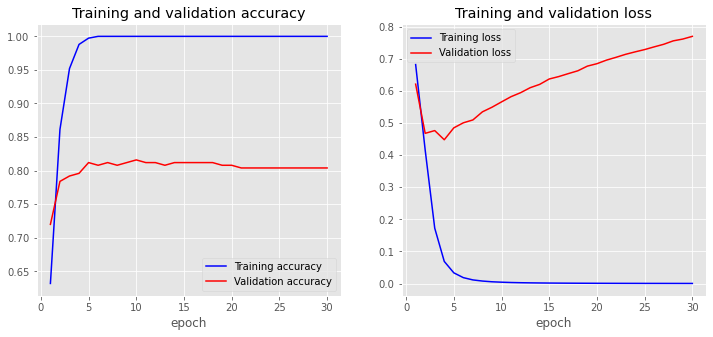

In [9]:
# plot
plt.style.use('ggplot')
def plot_history(history):
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('epoch')
plot_history(history)

Training Accuracy: 1.0000
Testing Accuracy:  0.7920


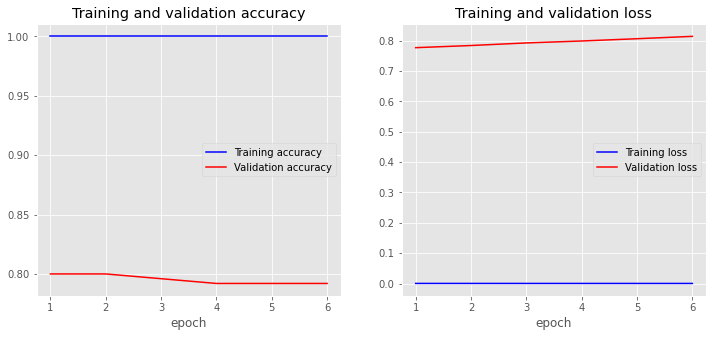

In [10]:
#* maybe early stop will be better ?
callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[callback])
clear_session()  # if we have too many models, just in case .

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
# not too much better - -!

# % Prepare trainning ref:
# https://realpython.com/python-keras-text-classification/

In [11]:
#* test  =>>
def sentiment(x,sentence):
    print(sentence)
    if x>0.5:
        print(f'Prediction is {x}, this may be positive sentiment')
    else:
        print(f'Prediction is {x}, this may be negtive sentiment')
sentence=['I not think good idea']
test  = vectorizer.transform(sentence)
sentiment(model.predict(test),sentence)

sentence2=['I love this idea']
test2 = vectorizer.transform(sentence2)
sentiment(model.predict(test2),sentence2)
# positive setiment 



['I not think good idea']
Prediction is [[0.00048769]], this may be negtive sentiment
['I love this idea']
Prediction is [[0.99978423]], this may be positive sentiment


In [12]:
#  The traning data is not very large to cover all possible opinions..
#  with larger data size and more layers, the accuracy should increase.

